# Handling Highly Imbalanced Data in Machine Learning Applications

## Authors

- Author1 = {"name": "Patrick M. O'Keefe", "affiliation": "New Jersey Institute of Technology", "email": "pmo6@njit.edu"}
- Author2 = {"name": "Viacheslav M. Sadykov", "affiliation": "Georgia State University", "email": "vsadykov@gsu.edu"}
- Author3 = {"name": "Alexander G. Kosovichev", "affiliation": "New Jersey Institute of Technology", "email": "alexander.g.kosovichev@njit.edu"}
- Author4 = {"name": "Gelu M. Nita", "affiliation": "New Jersey Institute of Technology", "email": "gnita@njit.edu"}
- Author5 = {"name": "Vincent Oria", "affiliation": "New Jersey Institute of Technology", "email": "vincent.oria@njit.edu"}
- Author6 = {"name": "Shantanu Sharma", "affiliation": "New Jersey Institute of Technology", "email": "shantanu.sharma@njit.edu"}
- Author7 = {"name": "Fraila Francis", "affiliation": "New Jersey Institute of Technology", "email": "ff29@njit.edu"}
- Author8 = {"name": "Chun Jie Chong", "affiliation": "New Jersey Institute of Technology", "email": "cc255@njit.edu"}

## Table of contents
- [Purpose](#purpose)
- [Technical contributions](#tech-contr)
- [Methodology](#methodology)
- [Results](#results)
- [Keywords](#keywords)
- [Citation](#citation)
- [Suggested next steps](#next-steps)
- [Setup](#setup)
    - [Library import](#library-import)
    - [Data import](#data-import)
- [Data processing and analysis](#data-pna)
    - [Using the raw data](#raw-data)
        - [Splitting the data into X and Y sets](#xy-split)
        - [Splitting the data into training and testing sets](#traintest-split)
        - [Defining and fitting the classifier](#classifier)
        - [Performing the initial analysis](#init-analysis)
        - [Measuring bias in the initial analysis](#bias-init-analysis)
    - [Bias correction](#bias-correction)
        - [Method 1: undersampling the data](#m1)
        - [Method 2: oversampling the data](#m2)
        - [Method 3: adjusting class weights](#m3)
        - [Method 4: trimming the trees](#m4)
        - [Method 5: using only events likely to be in the minority class](#m5)
        - [Method 6: putting it together](#m6)
- [Comparison of Data Obtained](#comp)
- [Conclusion](#conc)
- [Applicability to Other Algorithms](#app)
- [References](#ref)

## Purpose<a class="anchor" id="purpose"></a>
Machine learning techniques can be applied across various industries to make accurate predictions of future data points based on observed patterns. However, in cases where there are vast imbalances to training data, algorithms may default to the majority classes when predicting future data points and thus cause inaccuracy in predictions. This may be especially undesirable when predicting rare but dangerous activities such as solar proton events (SPE) that could damage sensitive electronics and affect the general ecosystem on Earth. Traditional methods to remedy class imbalance involve manipulation of the training data to create even splits between classes, but synthetically balanced data may be unrepresentative of the original data. There are, however, additional techniques that can be used without the risk of using sampled data that is unrepresentative of the original data.

In this work, we develop a database and analyze the application of various class-imbalance treatment techniques (oversampling, undersampling, class weight assignment) to build balanced classifiers for the prediction of whether the solar flare results in an SPE event, with the goal of developing an unbiased solution. Our data set consists of the soft X-ray properties of the solar flares detected by GOES satellite from 2001 to 2020, namely the peak values of the flux in 0.05-0.4 nm and 0.1-0.8 nm channels and related temperature and emission measure peak values derived with TEBBS algorithm. We utilize the balanced accuracy score and other assessment metrics (such as TSS and HSS) for the evaluation of the machine learning prediction. We find that vastly imbalanced data may be analyzed without the risks involved with oversampling or undersampling and accurate, unbiased classifications may be produced.


## Technical contributions<a class="anchor" id="tech-contr"></a>
- Demonstrating how machine learning applications can effectively function despite vast imbalances in training data.
    - Exploring various methods of handling class imbalance and quantifying their effectivenesses.
    - Exploring hyperparameters found within the methods of the SciKit-Learn library that can be adjusted to perform the requisite tasks.

## Methodology<a class="anchor" id="methodology"></a>
This notebook shows several examples of how data imbalances can be remedied.
- The imbalanced data is first analyzed and tested to give a benchmark metric.
- Evaluations are performed by computing accuracy scores to gauge the effectiveness of the classifier on the dataset.
    - Balanced accuracy scores, true skill statistics, and Heidke Skill Scores are used to gauge bias towards the majority class.
- Afterwards, various methods of imbalance correction are applied to the data and to the classifier.
- The various methods are compared in their accuracy metrics and their potential drawbacks.

## Results<a class="anchor" id="results"></a>
This notebook demonstrates how a machine learning application can effectively function despite vast imbalances in training data.

## Funding<a class="anchor" id="results"></a>
This work was supported from NSF grant number 1639683 and NASA grant number 80NSSC20K0302.

## Keywords<a class="anchor" id="keywords"></a>
keywords=["solar energetic particles", "machine learning", "databases"]

## Citation<a class="anchor" id="citation"></a>
O'Keefe et al 2022. Handling Highly Imbalanced Data in Machine Learning Applications. Accessed at https://github.com/earthcube2022/ec22_okeefe_etal.

## Suggested next steps<a class="anchor" id="next-steps"></a>
We recommend that developers of machine learning applications use our findings to remedy imbalances in their own organizations' data. We also recommend that developers of machine learning libraries add bias correction methods such as the ones being suggested or equivalents of them in more of their algorithms.

# Setup<a class="anchor" id="setup"></a>

## Library import<a class="anchor" id="library-import"></a>

In [1]:
import math
import random
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif

## Data import<a class="anchor" id="data-import"></a>
This data was previously downloaded from the flare database stored at https://solarflare.njit.edu. These flare parameters were automatically calculated there and are present in the file:

* MinDur: The duration of the flare in minutes.
* Tmax: The maximum temperature of the flare obtained in a one-temperature approximation.
* EMmax: The maximum emission measure of the flare obtained in a one-temperature approximation.
* PrecisePeak: The peak X-ray flux of the flare, measured in 10^-8 W/m^2.
* StartTo...: The time at which the respective parameter is achieved, measured in minutes after the start of the flare.
* ...ToEnd: The time at which the respective parameter is achieved, measured in minutes before the end of the flare.
* CausedSPE: Whether or not the flare caused an SPE event.

In [2]:
data = pd.read_json("./data/sunData.json")

# Data processing and analysis<a class="anchor" id="data-pna"></a>

## Using the raw data<a class="anchor" id="raw-data"></a>
### Splitting the data into X and Y sets<a class="anchor" id="xy-split"></a>
From the imported data, the data can be split into its features and classes:

In [3]:
X = data[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y = data['CausedSPE']

### Splitting the data into training and testing sets<a class="anchor" id="traintest-split"></a>

In [4]:
rs = 1
random.seed(rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)

### Defining and fitting the classifier<a class="anchor" id="classifier"></a>
According to Kathryn Whitman et al. (2022), models using empirical evidence of solar energetic activity are preferred by heliophysicists due to the relationships involved being quickly computed and easily applied to future flares. Seeing that the random forest algorithm performs several analyses of the data to obtain several sets of such evidence, it will be used in this particular application.

To increase the randomnesses of the decision trees in order to force the algorithm to produce more distinct analyses of the data, the number of features in any one decision tree is limited to the square root of the total number of features in the dataframe. To make sure that the application is making efficient use of all available processing resources, n_jobs is set to -1 to parallelize the application into as many jobs as possible.

This is all implemented as follows:

In [5]:
clf = RandomForestClassifier(max_features = "sqrt", n_jobs = -1, random_state = rs)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=1)

The classifier may be visualized as follows by taking its average depth and number of leaf nodes. For the purpose of comparison of each method, these statistics will be recorded in a DataFrame.

In [6]:
dfrf = pd.DataFrame(columns = ["Test", "AverageDepth", "AverageLeaves"])
def visualizeRandomForest(clf, df, test):
    avgDepth = 0
    avgLeaves = 0
    for i in range(0, len(clf.estimators_)):
        avgDepth += clf.estimators_[i].get_depth()
        avgLeaves += clf.estimators_[i].get_n_leaves()
    avgDepth /= len(clf.estimators_)
    avgLeaves /= len(clf.estimators_)
    print("Average depth: " + str(avgDepth))
    print("Average number of leaves: " + str(avgLeaves))
    df.loc[-1] = [test, avgDepth, avgLeaves]
    df.index += 1
    df = df.sort_index()
visualizeRandomForest(clf, dfrf, "Baseline")

Average depth: 11.7
Average number of leaves: 57.32


### Performing the initial analysis<a class="anchor" id="init-analysis"></a>
After the classifier has been fit with the training data, it can analyze the testing data and provide an accuracy score based on whether the predictions fell into the correct classes.

In [7]:
y_pred = clf.predict(X_test)
print("Accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.9969086021505377


### Measuring bias in the initial analysis<a class="anchor" id="bias-init-analysis"></a>
A score this high may sound impressive at first, but the data is heavily skewed in favor of the negative class, as seen below:

In [8]:
negClass = data[(data["CausedSPE"] == False)]
posClass = data[(data["CausedSPE"] == True)]
negClassSize = negClass.shape[0]
posClassSize = posClass.shape[0]
print("Negative class size: " + str(negClassSize))
print("Positive class size: " + str(posClassSize))

Negative class size: 24721
Positive class size: 76


To compare the characteristics of the data in each class, a histogram may be used to visualize the number of flares in various categories. For the sake of simplicity, only the PrecisePeak parameter of each flare will be shown, as it is the most important parameter as determined by this f classifier.

In [9]:
fs = SelectKBest(f_classif, k = 1)
X_new = fs.fit_transform(X, y)
mask = fs.get_support()
xCols = X.columns[mask]
print(xCols)

Index(['PrecisePeak'], dtype='object')


The histogram may be seen below. A logarithmic y-axis will be used to further help visualize the distributions of the data:

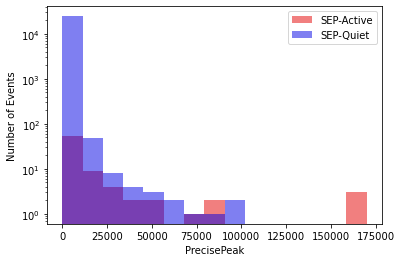

In [10]:
fig, ax = plt.subplots()
ax.hist(posClass['PrecisePeak'], label = "SEP-Active", color = "#e50000", alpha = 0.5, range = (0, max(max(posClass['PrecisePeak']), max(negClass['PrecisePeak']))), bins = 15, log = True)
ax.hist(negClass['PrecisePeak'], label = "SEP-Quiet", color = "#0000e5", alpha = 0.5, range = (0, max(max(posClass['PrecisePeak']), max(negClass['PrecisePeak']))), bins = 15, log = True)
ax.set_xlabel("PrecisePeak")
ax.set_ylabel("Number of Events")
ax.legend()
plt.show()

While a clean split can be visualized to some extent, many of the flares in the positive class have PrecisePeak values in a similar range as those in the negative class. Therefore, the bias of the algorithm must therefore be measured in order to see how fairly it is treating the data at face value. There are multiple methods of doing so.

First, the balanced accuracy score is used to measure the average of recall obtained on each class. Next, the true skill statistic (TSS) and Heidke Skill Score (HSS) are calculated as follows:

In [11]:
def compute_TSS(y_test, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    return tp/(tp + fn) - fp/(fp + tn)
def compute_HSS(y_test, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    return 2 * (tp * tn - fn * fp)/((tp + fn) * (fn + tn) + (tp + fp) * (tn + fp))

To view all of this information, we may build a performance table like so. For simplicity's sake, the metrics will be rounded to four decimal places. These metrics will also be stored for comparison.

In [12]:
dfpt = pd.DataFrame(columns = ["Test", "Accuracy", "BalancedAccuracy", "TSS", "HSS"])
def dispPerfTable(y_test, y_pred, df, test):
    acc = round(metrics.accuracy_score(y_test, y_pred), 4)
    bAcc = round(metrics.balanced_accuracy_score(y_test, y_pred), 4)
    TSS = round(compute_TSS(y_test, y_pred), 4)
    HSS = round(compute_HSS(y_test, y_pred), 4)
    retData = {'Metric':'Accuracy', 'Value':acc}, {'Metric':'Balanced Accuracy', 'Value':bAcc}, {'Metric':'TSS', 'Value':TSS}, {'Metric':'HSS', 'Value':HSS}
    print(pd.DataFrame.from_dict(retData))
    df.loc[-1] = [test, acc, bAcc, TSS, HSS]
    df.index += 1
    df = df.sort_index()
dispPerfTable(y_test, y_pred, dfpt, "Baseline")

              Metric   Value
0           Accuracy  0.9969
1  Balanced Accuracy  0.4999
2                TSS -0.0001
3                HSS -0.0003


Seeing that the initial score is indeed hiding bias in favor of the majority class, the bias needs to be corrected in order to obtain a fair analysis.
## Bias correction<a class="anchor" id="bias-correction"></a>
There are several methods of correcting biases in order to obtain fair analyses.
### Method 1: undersampling the data<a class="anchor" id="m1"></a>
This simply involves removing data from both classes in order to produce data sets of equal size. With this method, there is no need to produce synthetic data in order to balance out the classes, but the classifier will not have much to if the data sets are very small in size.

To mitigate the possibility of the new training data having duplicate records of the testing data, the training and testing sets will need to be redefined.

The data is resized and the classifier is refit and visualized as follows:

In [13]:
data_train, data_test = train_test_split(data, test_size = 0.3, random_state = rs)
causedSpeTrain = data_train[data_train['CausedSPE'] == True]
noSpeTrain = data_train[data_train['CausedSPE'] == False]
speTrainData = resample(causedSpeTrain, n_samples = int(posClassSize * 0.7))
noSpeTrainData = resample(noSpeTrain, n_samples = int(posClassSize * 0.7))
newDataTrain = pd.concat([speTrainData, noSpeTrainData])
X_train = newDataTrain[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y_train = newDataTrain['CausedSPE']
X_test = data_test[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y_test = data_test['CausedSPE']
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Undersampled")

Average depth: 4.38
Average number of leaves: 7.31


The performance table for this test may be seen here:

In [14]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Undersampled")

              Metric   Value
0           Accuracy  0.9606
1  Balanced Accuracy  0.9123
2                TSS  0.8245
3                HSS  0.1099


While the results seem promising, with the undersampled data, there is not much data to draw empirical analyses from, so problems may only arise in the long run.

### Method 2: oversampling the data<a class="anchor" id="m2"></a>
The opposite approach to that taken previously is taken with this method: the data sets are enlarged to make them even in size. This does give the classifier more data to work with, but it uses synthetic data that may be unrepresentative of either class.

The data is resized again and the classifier is refit and visualized:

In [15]:
speTrainData = resample(causedSpeTrain, n_samples = int(data.size * 0.35))
noSpeTrainData = resample(noSpeTrain, n_samples = int(data.size * 0.35))
newDataTrain = pd.concat([speTrainData, noSpeTrainData])
X_train = newDataTrain[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y_train = newDataTrain['CausedSPE']
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Oversampled")

Average depth: 27.73
Average number of leaves: 101.72


The performance table for this test may be seen here:

In [16]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Oversampled")

              Metric   Value
0           Accuracy  0.9965
1  Balanced Accuracy  0.5904
2                TSS  0.1807
3                HSS  0.2337


Here, the opposite problem is encountered: the class definitions have been changed and it is therefore more difficult to use any new data outside of the original set thanks to the data in the training set being copied many times over. While TSS and HSS metrics may have improved from their baseline counterparts, balanced accuracy has only made a slight, if any, improvement.

### Method 3: adjusting class weights<a class="anchor" id="m3"></a>
Sklearn's RandomForestClassifier has a built-in feature that allows one to tune the classifier so that the weight of each class is inversely proportional to the class frequencies of the input data.

The classifier is first refit and visualized:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)
clf = RandomForestClassifier(class_weight = "balanced", max_features = "sqrt", n_jobs = -1, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Balanced Class Weights")

Average depth: 23.71
Average number of leaves: 77.63


The performance table for this test may be seen here:

In [18]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Balanced Class Weights")

              Metric   Value
0           Accuracy  0.9969
1  Balanced Accuracy  0.5226
2                TSS  0.0452
3                HSS  0.0793


While any improvement to the baseline data would be slight, there is no need to synthesize data, nor is there a need to deprive the classifier of training data.

The class weights may also be manually specified. In this example, the weights are determined by the probability of a data point being in the opposite class. The classifier is refit and visualized here:

In [19]:
classSizeSum = negClassSize + posClassSize
negClassPortion = negClassSize / classSizeSum
posClassPortion = posClassSize / classSizeSum
clf = RandomForestClassifier(class_weight = {0:posClassPortion, 1:negClassPortion}, max_features = "sqrt", n_jobs = -1, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Opposite Class Weights")

Average depth: 24.1
Average number of leaves: 78.85


The performance table for this test may be seen here:

In [20]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Opposite Class Weights")

              Metric   Value
0           Accuracy  0.9965
1  Balanced Accuracy  0.5224
2                TSS  0.0448
3                HSS  0.0703


Again, little improvement, if any, is made to the baseline data, though there is no need to alter the number of samples in the training data.

### Method 4: trimming the trees<a class="anchor" id="m4"></a>
Until now, absolutely all data points in the training and testing sets were considered, leading to the potential for anomalies to cause counterproductive overanalysis. This can be remedied by adjusting the cost complexities of the trees and choosing the largest subtree with a cost complexity lower than the specified alpha value. The total cost complexity of a tree is the sum of the rate of misclassification and the product of the alpha value and the number of leaf nodes in the tree.

For the examples in this notebook, an alpha value of 0.01 will be used.

This can be implemented in Python as shown here, with the same measurements as before taken again:

In [21]:
clf = RandomForestClassifier(max_features = "sqrt", n_jobs = -1, ccp_alpha = 0.01, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Trimmed Trees")

Average depth: 0.0
Average number of leaves: 1.0


While this will mean the data will likely not be very accurately classified, here is the performance table for this test anyway for comparison:

In [22]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Trimmed Trees")

              Metric  Value
0           Accuracy  0.997
1  Balanced Accuracy  0.500
2                TSS  0.000
3                HSS  0.000


While this method does not necessarily function in isolation, this can improve results that already have bias correction applied. For this example, this will be demonstrated with the adjusted class weights to avoid the need for synthesis or removal of data, as either, again, may change the definition of either class or provide insufficient training data.

When combined with the balanced class weights, here is the visualization of the classifier:

In [23]:
clf = RandomForestClassifier(class_weight = "balanced", max_features = "sqrt", n_jobs = -1, ccp_alpha = 0.01, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Trimmed Trees with Balanced Class Weights")

Average depth: 3.59
Average number of leaves: 5.96


The performance table for this test may be seen here:

In [24]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Trimmed Trees with Balanced Class Weights")

              Metric   Value
0           Accuracy  0.9630
1  Balanced Accuracy  0.9135
2                TSS  0.8270
3                HSS  0.1165


With opposite class weights, here is the visualization of the classifier:

In [25]:
clf = RandomForestClassifier(class_weight = {0:posClassPortion, 1:negClassPortion}, max_features = "sqrt", n_jobs = -1, ccp_alpha = 0.01, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Trimmed Trees with Opposite Class Weights")

Average depth: 3.62
Average number of leaves: 6.11


The performance table for this test may be seen here:

In [26]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Trimmed Trees with Opposite Class Weights")

              Metric   Value
0           Accuracy  0.9614
1  Balanced Accuracy  0.9353
2                TSS  0.8707
3                HSS  0.1175


### Method 5: using only events likely to be in the minority class<a class="anchor" id="m5"></a>
While undersampling in general may only lead to a classifier having insufficient data to base calculations on, strategic undersampling can isolate events that are either borderline or likely to appear in the minority class. Performing a complete analysis on which events fall into this category can be just as cumbersome as performing the analyses already performed, so it may be beneficial to isolate the most important element for consideration.

As determined earlier through an f classifier, the PrecisePeak parameter is the most important.

Next, this "liar's poker" system will determine which PrecisePeak value should be used as a threshold for more commonly occurring SPEs. It gathers the PrecisePeak parameters of all flares in the positive class as well as the same parameters in the negative class. It eliminates ranges from both lists that are less commonly found in the other as proportions of their respective lengths and selects the last value of the "lower" array to use as the threshold. The latter is determined by taking the arithmetic means of the unique values in both arrays.

Prior to this point, outliers were not removed from the database because any slight change in the number of elements in it could completely erase the minority class. However, since the elements of both classes are isolated in order to obtain this threshold, removing the outliers from both classes is a must in order to obtain a threshold that does not correspond to an anomaly in either class.

The threshold is computed as follows:

In [27]:
def removeOutliers(arr):
    q1 = arr[int(len(arr) / 4)]
    q3 = arr[int(3 * len(arr) / 4)]
    iqr = q3 - q1
    q1r = q1 - (1.5 * iqr)
    q3r = q3 + (1.5 * iqr)
    delValues = []
    for i in range(0, len(arr)):
        if(arr[i] > q3r or arr[i] < q1r):
            if(arr[i] not in delValues):
                delValues.append(arr[i])
    for i in range(0, len(delValues)):
        if(delValues[i] in arr):
            arr = list(filter((delValues[i]).__ne__, arr))
    return arr
def commonalityThreshold(arrA, arrB):
    smallArr = []
    bigArr = []
    if(len(arrA) < len(arrB)):
        smallArr = arrA
        bigArr = arrB
    else:
        smallArr = arrB
        bigArr = arrA
    uniqueBigArr = list(np.unique(bigArr))
    uniqueSmallArr = list(np.unique(smallArr))
    for i in range(0, len(uniqueBigArr) - 1):
        minI = uniqueBigArr[i]
        maxI = uniqueBigArr[i + 1]
        bigRangeCountI = int(len(list(x for x in bigArr if minI <= x < maxI)) / len(bigArr))
        smallRangeCountI = int(len(list(x for x in smallArr if minI <= x < maxI)) / len(smallArr))
        delValuesI = []
        if(bigRangeCountI > smallRangeCountI):
            for k in range(0, len(smallArr)):
                if(smallArr[k] >= minI and smallArr[k] < maxI):
                    delValuesI.append(smallArr[k])
            for k in range(0, len(delValuesI)):
                if(delValuesI[k] in smallArr):
                    smallArr = list(filter((delValuesI[k]).__ne__, smallArr))
        elif(smallRangeCountI > bigRangeCountI):
            for k in range(0, len(smallArr)):
                if(bigArr[k] >= minI and bigArr[k] < maxI):
                    delValuesI.append(bigArr[k])
            for k in range(0, len(delValuesI)):
                if(delValuesI[k] in bigArr):
                    bigArr = list(filter((delValuesI[k]).__ne__, bigArr))
    for j in range(0, len(uniqueSmallArr) - 1):
        minJ = uniqueSmallArr[j]
        maxJ = uniqueSmallArr[j + 1]
        bigRangeCountJ = int(len(list(x for x in bigArr if minJ <= x < maxJ)) / len(bigArr))
        smallRangeCountJ = int(len(list(x for x in smallArr if minJ <= x < maxJ)) / len(smallArr))
        delValuesJ = []
        if(bigRangeCountJ > smallRangeCountJ):
            for k in range(0, len(smallArr)):
                if(smallArr[k] >= minJ and smallArr[k] < maxJ):
                    delValuesJ.append(smallArr[k])
            for k in range(0, len(delValuesJ)):
                if(delValuesJ[k] in smallArr):
                    smallArr = list(filter((delValuesJ[k]).__ne__, smallArr))
        elif(smallRangeCountJ > bigRangeCountJ):
            for k in range(0, len(smallArr)):
                if(bigArr[k] >= minJ and bigArr[k] < maxJ):
                    delValuesJ.append(bigArr[k])
            for k in range(0, len(delValuesJ)):
                if(delValuesJ[k] in bigArr):
                    bigArr = list(filter((delValuesJ[k]).__ne__, bigArr))
    uniqueBigArr = list(np.unique(bigArr))
    uniqueSmallArr = list(np.unique(smallArr))
    if((sum(uniqueBigArr) / len(uniqueBigArr)) < (sum(uniqueSmallArr) / len(uniqueSmallArr))):
        return uniqueBigArr[-1]
    else:
        return uniqueSmallArr[-1]
dps = data[['PrecisePeak', 'CausedSPE']]
dpst = dps[(dps['CausedSPE'] == True)]
sortedPeaksT = sorted(dpst['PrecisePeak'])
sortedPeaksT = removeOutliers(sortedPeaksT)
uniqueSortedPeaksT = list(np.unique(sortedPeaksT))
dpsf = dps[(dps['CausedSPE'] == False)]
sortedPeaksF = sorted(dpsf['PrecisePeak'])
sortedPeaksF = removeOutliers(sortedPeaksF)
uniqueSortedPeaksF = list(np.unique(sortedPeaksF))
precisePeakThreshold = commonalityThreshold(sortedPeaksT, sortedPeaksF)
print(precisePeakThreshold)

570.0


This corresponds to a threshold of GOES class C5.7. This result is validated by Arnold O. Benz et al's (2007) observations that flares of class C5 and greater in general cause radio events.

The refit classifier may be visualized here:

In [28]:
benz_data_train = data_train[(data_train['PrecisePeak'] > precisePeakThreshold)]
X_train = benz_data_train[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y_train = benz_data_train['CausedSPE']
X_test = data_test[['MinDur', 'Tmax', 'EMmax', 'PrecisePeak', 'StartToTmax', 'TmaxToEnd', 'StartToEMmax', 'EMmaxToEnd', 'StartToPeak', 'PeakToEnd']]
y_test = data_test['CausedSPE']
clf = RandomForestClassifier(max_features = "sqrt", n_jobs = -1, random_state = 1)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Edge Cases Only")

Average depth: 11.14
Average number of leaves: 48.71


The performance table for this test may be seen here:

In [29]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Edge Cases Only")

              Metric   Value
0           Accuracy  0.9962
1  Balanced Accuracy  0.4996
2                TSS -0.0008
3                HSS -0.0013


Removing cases that are likely to be in the majority class may improve antibiased metrics thanks to the classifier not being able to default to the majority class for the data most likely to appear in it, but the improvement may still only be slight if there is any improvement at all.

### Method 6: putting it together<a class="anchor" id="m6"></a>
When combined with the aforementioned solution of trimming the trees and balancing the class weights, here is the classifier refit and visualization with balanced class weights:

In [30]:
clf = RandomForestClassifier(class_weight = "balanced", max_features = "sqrt", n_jobs = -1, ccp_alpha = 0.01, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Edge Cases Only with Trimmed Trees and Balanced Class Weights")

Average depth: 4.99
Average number of leaves: 9.02


The performance table for this test may be seen here:

In [31]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Edge Cases Only with Trimmed Trees and Balanced Class Weights")

              Metric   Value
0           Accuracy  0.9876
1  Balanced Accuracy  0.9032
2                TSS  0.8063
3                HSS  0.2777



With opposite class weights, here is the refit classifier and its visualization:

In [32]:
clf = RandomForestClassifier(class_weight = {0:posClassPortion, 1:negClassPortion}, max_features = "sqrt", n_jobs = -1, ccp_alpha = 0.01, random_state = rs)
clf.fit(X_train, y_train)
visualizeRandomForest(clf, dfrf, "Edge Cases Only with Trimmed Trees and Opposite Class Weights")

Average depth: 3.79
Average number of leaves: 5.67


The performance table for this test may be seen here:

In [33]:
y_pred = clf.predict(X_test)
dispPerfTable(y_test, y_pred, dfpt, "Edge Cases Only with Trimmed Trees and Opposite Class Weights")

              Metric   Value
0           Accuracy  0.9653
1  Balanced Accuracy  0.9373
2                TSS  0.8746
3                HSS  0.1295


Combining the previous two methods signifies a <i>slight</i> improvement in metrics: the HSS score of the balanced class weight test has notably improved, but not much else has changed from the tests in Method 4.
# Comparison of Data Obtained<a class="anchor" id="comp"></a>
Here are the average tree depths in each of the previous classifiers:

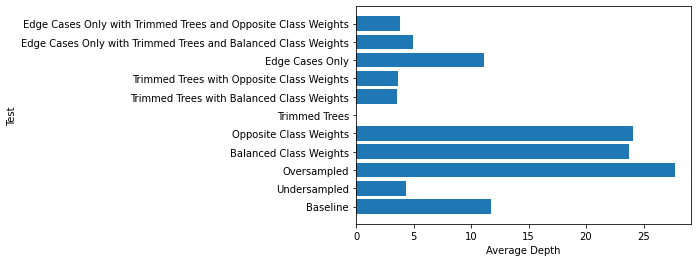

In [34]:
fig, ax = plt.subplots()
tests = dfrf["Test"]
x = np.arange(len(tests))
ax.barh(x, dfrf["AverageDepth"])
ax.set_ylabel("Test")
ax.set_xlabel("Average Depth")
ax.set_yticks(x)
ax.set_yticklabels(tests.astype(str).values, rotation = "horizontal")
plt.show()

Here are the average numbers of leaves:

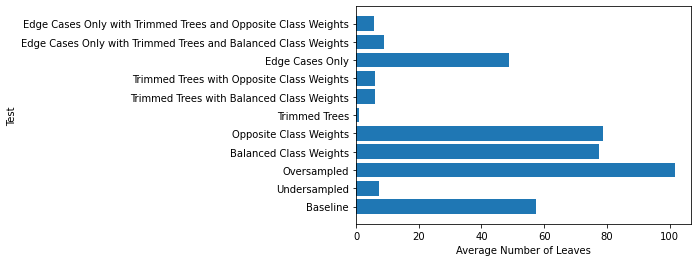

In [35]:
fig, ax = plt.subplots()
tests = dfrf["Test"]
x = np.arange(len(tests))
ax.barh(x, dfrf["AverageLeaves"])
ax.set_ylabel("Test")
ax.set_xlabel("Average Number of Leaves")
ax.set_yticks(x)
ax.set_yticklabels(tests.astype(str).values, rotation = "horizontal")
plt.show()

Here are the values from the performance tables:

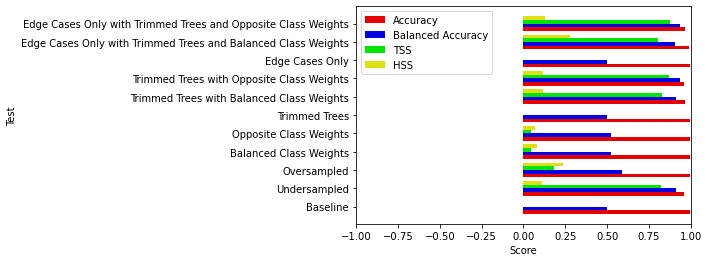

In [36]:
fig, ax = plt.subplots()
tests = dfpt["Test"]
x = np.arange(len(tests))
width = 0.2
ax.barh(x - 3 * width / 2, dfpt["Accuracy"], width, label = "Accuracy", color = "#e50000")
ax.barh(x - width / 2, dfpt["BalancedAccuracy"], width, label = "Balanced Accuracy", color = "#0000e5")
ax.barh(x + width / 2, dfpt["TSS"], width, label = "TSS", color = "#00e500")
ax.barh(x + 3 * width / 2, dfpt["HSS"], width, label = "HSS", color = "#dfdf14")
ax.set_ylabel("Test")
ax.set_xlabel("Score")
ax.set_yticks(x)
ax.set_yticklabels(tests.astype(str).values, rotation = "horizontal")
ax.set_axisbelow(True)
ax.set_xlim([-1, 1])
ax.legend()
plt.show()

# Conclusion<a class="anchor" id="conc"></a>
Based on the data presented here, it is possible to run a machine learning application with highly imbalanced data. However, there are certain antibiasing methods that work better than others. Depriving the algorithm of training data or adding synthetic data may force the algorithm to make inaccurate predictions based on a lack of data or based on duplicate data, but strategic undersampling may <i>slightly</i> improve scores by not allowing the algorithm to default to the majority class based on data that is more likely to appear in it. Adjusting class weights can improve antibiased scores without resizing the data and causing these potential issues, especially when combined with limiting the number of branches in the tree to avoid overanalysis of anomalous data. Combining strategic undersampling, adjusted class weights, and limited tree depth may improve scores even further: the HSS metric from using the balanced class weights and the limited tree depths notably improves by using strategically undersampled training data. From this information, it may be concluded that using adjusted class weights and leaving out anomalies in analyses are the best actions to take and cause the least uncertainty, but combining these techniques with strategic undersampling may improve metrics further when balanced class weights are used.
# Applicability to Other Algorithms<a class="anchor" id="app"></a>
There are also other, similar methods of correcting class imbalances that can be used when implementing other algorithms. For example, class weights in a neural network classifier can also be adjusted as a hyperparameter and dropout layers can be used to filter anomalies that could cause overfitting. 

# References<a class="anchor" id="ref"></a>
[1] Whitman, K. et al. (2022). Review of Solar Energetic Particle Models. Advances in Space Research, 6. Submitted for publication.

[2] Benz, A.O. et al. (2007). Are there Radio-quiet Solar Flares? Cornell University, 1. https://arxiv.org/pdf/astro-ph/0701570.pdf